# Devils DFTD Parameter Fitting
Plot for Devils simulation with and without DFTD

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

## Read in observed data

In [3]:
pop_data = pd.read_csv('Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
carry_cap = int(max(devil_pop)*1.16)

## Load Simulation data and Paramter Sweeps

In [4]:
with open('figure_data/Fig3B_Fig14B-C-data.p', 'rb') as fd:
    sim_data = pickle.load(fd)
    
    variables = sim_data['variables']
    sweeps = sim_data['sweeps']
    eresults = sim_data['eresults']
    mean_std_db = sim_data['mean_std_db']

## Plotting functions and helpers

In [5]:
def make_filename(variables):
    cmdpath = "ParameterSweeps/tmp_result_state"
    ret = 'ps-'
    for key in sorted(variables.keys()):
        value = float(variables[key])
        ret += f"{value:.4e},"
    return os.path.join(cmdpath, ret)

In [6]:
def get_mean_std(var):
    f = make_filename(var)
    if f in mean_std_db:
        return mean_std_db[f]

In [7]:
def plot_eresult(eresults): 
    fig, ax1 = plt.subplots(figsize=[12, 6])

    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
    ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax1.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
    ax1.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
    ax1.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
    ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
    ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
    ax1.text(variables['DFTD_start']-7, 24000, dates[variables['DFTD_start']], rotation="vertical", color="black", fontsize=14)
    ax1.tick_params(axis='x', labelsize=12)
    
    x_ticks = list(range(0, 421, 60))
    x_ticklabels = []
    for i in x_ticks:
        x_ticklabels.append(dates[i])

    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.set_yticks([20000,40000,60000])
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=16)
    ax1.set_ylim([0, carry_cap])
    ax1.set_xlim(0,eresults[0]['time'][-1])
    for n,r in enumerate(eresults):
        if n==0: continue
        ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
        ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
        ax1.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
        ax1.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
        ax1.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')

    print(variables)
    
    def calculate_distance(eresults):
        '''return mean/stddev of L2 norm distance'''
        global obs
        dists = np.zeros(len(eresults))
        for n,r in enumerate(eresults):
            dists[n] = np.linalg.norm(r['Devils']-obs[0][0],2)
        return np.average(dists), np.std(dists)

    dist_l2 = calculate_distance(eresults)
    print(f"L2 = {dist_l2[0]:.2f} +/-{dist_l2[1]:.2f}")

In [8]:
def plot_sweep(name, nrows, ncols, nplots, ymax, my_yticks):
    global pltcnt
    xvals = np.zeros(len(sweeps[name]))
    mvals = np.zeros(len(sweeps[name]))
    svals = np.zeros(len(sweeps[name]))
    
    for n, v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = float(v)
        try:
            (m, s) = get_mean_std(c)
            xvals[n] = c[name]
            mvals[n] = m
            svals[n] = s
        except Exception as e:
            print(f"caught e={e} while name={name}")
    
    ax1 = plt.subplot(nrows, ncols, nplots)
    ax1.errorbar(xvals, mvals, yerr=svals, capsize=10)
    ax1.plot([variables[name], variables[name]], [0, 100000], '--')
    ax1.text(float(sweeps[name][-1]), 10000, name, fontsize=16, ha='right')
    ax1.set_ylim(0, ymax)
    if pltcnt%2==1:
        ax1.set_ylabel('Error', fontsize=14)
        ax1.set_yticks(my_yticks)
        ax1.tick_params('y', labelsize=14, labelrotation=90)
    else:
        ax1.set_yticks([])
    ax1.tick_params('x', labelsize=14)

## Run Parameter Sweep

In [9]:
variables

{'juvenile_concentration': 0.49534348836011316,
 'birth_rate': 0.055,
 'maturity_rate': 0.04,
 'death_rate_juvenile': 0.007,
 'death_rate_over_population': 2.3e-07,
 'death_rate_susceptible': 0.02335,
 'incubation': 10.25,
 'progression': 10.74,
 'infection_rate_diseased': 3.84e-05,
 'infection_rate_infected': 1e-05,
 'death_rate_diseased': 0.29017,
 'death_rate_infected': 0.022609,
 'DFTD_start': 100}

In [10]:
print("Parameter                sweep min value  current value")
print("---------                ---------------  -------------")
for name in ['infection_rate_infected','infection_rate_diseased',
             'incubation','progression','death_rate_infected',
             'death_rate_diseased','DFTD_start']:
    xvals = np.zeros(len(sweeps[name]))
    mvals = np.zeros(len(sweeps[name]))
    svals = np.zeros(len(sweeps[name]))
    for n,v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = float(v)
        try:
            (m,s) = get_mean_std(c)
            xvals[n]=c[name]
            mvals[n]=m
            svals[n]=s
        except Exception as e:
            print(f"caught e={e} while name={name} ")
    minx=math.inf
    for n in range(len(xvals)):
        if mvals[n] < minx:
            minx=mvals[n]
            minn=n
    print(f"{name} {' '*(23-len(name))} {xvals[minn]} {' '*(15-len(str(xvals[minn])))} {variables[name]}")

Parameter                sweep min value  current value
---------                ---------------  -------------
infection_rate_infected  9.75e-06         1e-05
infection_rate_diseased  4.224e-05        3.84e-05
incubation               10.25            10.25
progression              11.814           10.74
death_rate_infected      0.020348         0.022609
death_rate_diseased      0.30468          0.29017
DFTD_start               102.0            100


## Calculate total length of DFTD disease
From "exposure" to "death" (in months)

In [11]:
1/variables['death_rate_diseased'] + variables['incubation'] + variables['progression']

24.436255643243616

## Plots for Figure 3 B

{'juvenile_concentration': 0.49534348836011316, 'birth_rate': 0.055, 'maturity_rate': 0.04, 'death_rate_juvenile': 0.007, 'death_rate_over_population': 2.3e-07, 'death_rate_susceptible': 0.02335, 'incubation': 10.25, 'progression': 10.74, 'infection_rate_diseased': 3.84e-05, 'infection_rate_infected': 1e-05, 'death_rate_diseased': 0.29017, 'death_rate_infected': 0.022609, 'DFTD_start': 100}
L2 = 48763.60 +/-19805.96


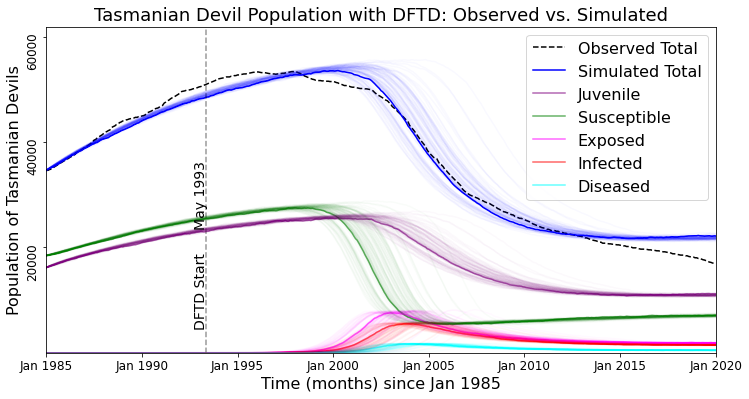

In [12]:
plot_eresult(eresults)

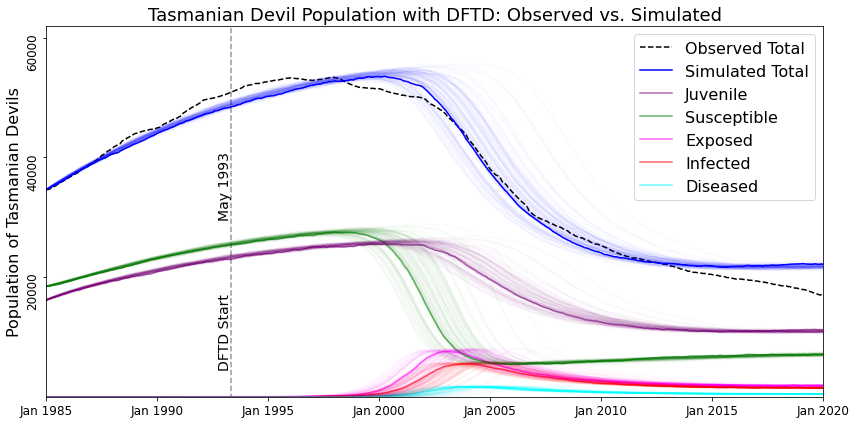

In [13]:
fig, ax1 = plt.subplots(figsize=[12, 6])

plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
ax1.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
ax1.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
ax1.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
ax1.text(variables['DFTD_start']-7, 30000, dates[variables['DFTD_start']], rotation="vertical", color="black", fontsize=14)
ax1.tick_params(axis='x', labelsize=12)

x_ticks = list(range(0, 421, 60))
x_ticklabels = []
for i in x_ticks:
    x_ticklabels.append(dates[i])

ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels)
ax1.set_yticks([20000,40000,60000])
ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
ax1.legend(loc='upper right', fontsize=16)
ax1.set_ylim([0, carry_cap])
ax1.set_xlim(0,eresults[0]['time'][-1])
for n,r in enumerate(eresults):
    if n==0: continue
    ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
    ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
    ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
    ax1.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
    ax1.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
    ax1.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')

plt.tight_layout()
# plt.savefig("figures/figure3B_no_inset.pdf")

## Plots for Figure 14 B

### Check the DFTD parameters

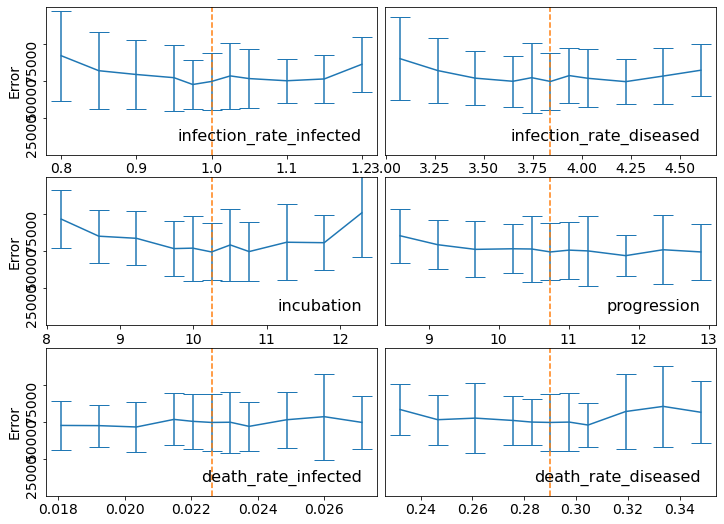

In [14]:
plt.figure(figsize=[12, 9])
pltcnt=1
plot_sweep('infection_rate_infected',3, 2, pltcnt, 100000, [25000, 50000, 75000]);pltcnt+=1
plot_sweep('infection_rate_diseased',3, 2, pltcnt, 100000, [25000, 50000, 75000]);pltcnt+=1
plot_sweep('incubation',3, 2, pltcnt, 100000, [25000, 50000, 75000]);pltcnt+=1
plot_sweep('progression',3, 2, pltcnt, 100000, [25000, 50000, 75000]);pltcnt+=1
plot_sweep('death_rate_infected',3, 2, pltcnt, 100000, [25000, 50000, 75000]);pltcnt+=1
plot_sweep('death_rate_diseased',3, 2, pltcnt, 100000, [25000, 50000, 75000]);pltcnt+=1
plt.subplots_adjust(wspace=0.025, hspace=0.15)
# plt.savefig("figures/figure4C.pdf")

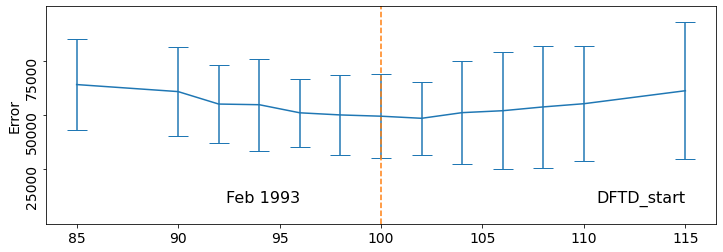

In [15]:
plt.figure(figsize=[12, 4])
plot_sweep('DFTD_start', 1, 1, 1, 100000, [25000, 50000, 75000])
plt.text(96,10000,"Feb 1993",ha='right', fontsize=16)
# plt.savefig("figures/figure4B.pdf")